In [14]:
import numpy as np
import os
from glob import glob
import PIL
import mne
import re
import pandas as pd
from statistics import mean
from statistics import stdev

In [ ]:
file_epi="/Volumes/SkAnDH_Xb/EPILEPSY_corr/epilepsy/"
file_no_epi="/Volumes/SkAnDH_Xb/EPILEPSY_corr/no_epilepsy/"
epi_edf_files = [y for x in os.walk(file_epi) for y in glob(os.path.join(x[0], '*.edf'))]
no_epi_edf_files = [y for x in os.walk(file_no_epi) for y in glob(os.path.join(x[0], '*.edf'))]

# Removing Eye movement using ICA

In [ ]:
for epi in epi_edf_files:
    raw=mne.io.read_raw_edf(epi,preload=True)
    raw_tmp = raw.copy()
    raw_tmp.filter(1, None)
    ica = mne.preprocessing.ICA(method="infomax", random_state=1)
    ica.fit(raw_tmp)
    raw_corrected = raw.copy()
    ica.apply(raw_corrected)
    raw_corrected.save(epi)
    
for epi in no_epi_edf_files:
    raw=mne.io.read_raw_edf(epi,preload=True)
    raw_tmp = raw.copy()
    raw_tmp.filter(1, None)
    ica = mne.preprocessing.ICA(method="infomax", random_state=1)
    ica.fit(raw_tmp)
    raw_corrected = raw.copy()
    ica.apply(raw_corrected)
    raw_corrected.save(epi)

# Channel selection with dataset segregation

In [ ]:
grail="EEG FP1-REF EEG FP2-REF EEG F3-REF EEG F4-REF EEG C3-REF EEG C4-REF EEG P3-REF EEG P4-REF EEG O1-REF EEG O2-REF EEG F7-REF EEG F8-REF EEG T3-REF EEG T4-REF EEG T5-REF EEG T6-REF EEG A1-REF EEG A2-REF EEG FZ-REF EEG CZ-REF EEG PZ-REF EEG ROC-REF EEG LOC-REF EEG EKG1-REF EMG-REF EEG 26-REF EEG 27-REF EEG 28-REF EEG 29-REF EEG 30-REF EEG T1-REF EEG T2-REF PHOTIC-REF IBI BURSTS SUPPR"

corr_epi_files=[]
for i in epi_edf_files:
    #f.close()
    f = pyedflib.EdfReader(i)
    signal_labels = f.getSignalLabels()
    head=" ".join(signal_labels)
    if head==grail:
        corr_epi_files.append(i)
    f.close()

set_list=[]
for i in headers_list:
    set_list.append(" ".join(i))

for i in set(set_list):
    print(set_list.count(i))

corr_non_epi_files=[]
for i in no_epi_edf_files:
    #f.close()
    f = pyedflib.EdfReader(i)
    signal_labels = f.getSignalLabels()
    head=" ".join(signal_labels)
    if head==grail:
        corr_non_epi_files.append(i)
    f.close()

set_list_2=[]
for i in headers_list_2:
    set_list_2.append(" ".join(i))
for i in set(set_list_2):
    if set_list_2.count(i)>150:
        print(i)

for i in set(set_list):
    if set_list.count(i)>400:
        print(i)
        
for epi in corr_epi_files:
    try:
        tx=epi.replace(".edf",".txt")
        tx=re.sub('_t0[0-9]*','', tx)
        cmd_1="cp "+str(epi)+" /Volumes/SkAnDH_Xb/EPILEPSY_corr/epilepsy/"
        cmd_2="cp "+str(tx)+" /Volumes/SkAnDH_Xb/EPILEPSY_corr/epilepsy/"
        os.system(cmd_1)
        os.system(cmd_2)
    except e: 
        print(e)


for no_epi in corr_non_epi_files:
    try:
        tx=no_epi.replace(".edf",".txt")
        tx=re.sub('_t0[0-9]*','', tx)
        cmd_1="cp "+str(no_epi)+" /Volumes/SkAnDH_Xb/EPILEPSY_corr/no_epilepsy/"
        cmd_2="cp "+str(tx)+" /Volumes/SkAnDH_Xb/EPILEPSY_corr/no_epilepsy/"
        os.system(cmd_1)
        os.system(cmd_2)
    except e: 
        print(e)

# Creating dataset

In [ ]:
channels=mne.io.read_raw_edf(epi_edf_files[0],preload=True)
channels=channels.ch_names
channels=channels[:-4]
channels.remove("EMG-REF")

print("converting EPILEPSY")
s=0
mne.set_log_level("WARNING")
for heads in range(0,31):
    print(channels[heads])
    df = pd.DataFrame(columns=["data"])
    df["data"] = df["data"].astype(object)
    for epi in range(len(epi_edf_files)):
        data=mne.io.read_raw_edf(epi_edf_files[epi],preload=True)
        arr=data.get_data(heads)[0]
        df.loc[epi,"data"] = list(arr)
        data.close()
        print(s)
        s+=1
    df.to_csv("/Volumes/SkAnDH_Xb/EPILEPSY_corr/epilepsy/"+str(channels[heads])+".csv")
    del df

s=0
for heads in range(0,31):
    print(channels[heads])
    df = pd.DataFrame(columns=["data"])
    df["data"] = df["data"].astype(object)
    for epi in range(len(no_epi_edf_files)):
        data=mne.io.read_raw_edf(no_epi_edf_files[epi],preload=True)
        arr=data.get_data(heads)[0]
        df.loc[epi,"data"] = list(arr)
        data.close()
        print(s)
        s+=1
    df.to_csv("/Volumes/SkAnDH_Xb/EPILEPSY_corr/no_epilepsy/"+str(channels[heads])+".csv")
    del df

In [ ]:
names=os.listdir("/Users/skandhvinayak/Downloads/epilepsy/")
data_frames=[]
for n in names:
    df1=pd.read_csv("/Users/skandhvinayak/Downloads/epilepsy/"+n,index_col=False)
    df1=df1.drop(columns=["Unnamed: 0"])
    df1=df1.sample(frac=1).reset_index(drop=True)
    df2=pd.read_csv("/Users/skandhvinayak/Downloads/no_epilepsy/"+n,index_col=False)
    df2=df2.drop(columns=["Unnamed: 0"])
    df2=df2.sample(frac=1).reset_index(drop=True)
    df1=df1.append(df2)
    df1=df1.sample(frac=1).reset_index(drop=True)
    data_frames.append(df1)

# Metadata Analysis

In [13]:
file_epi="/Volumes/SkAnDH_Xb/EPILEPSY_corr/epilepsy/"
file_no_epi="/Volumes/SkAnDH_Xb/EPILEPSY_corr/no_epilepsy/"
epi_txt_files = [y for x in os.walk(file_epi) for y in glob(os.path.join(x[0], '*.txt'))]
no_epi_txt_files = [y for x in os.walk(file_no_epi) for y in glob(os.path.join(x[0], '*.txt'))]

ages=[]
male_epi=0
female_epi=0
for txt_file in epi_txt_files:
    try:
        with open(txt_file,"r") as f:
            txts=f.readlines()
            texts=[]
            for t in txts:
                if "year-old" in t:
                    k=t.replace("-"," ")
                    li=k.split(" ")
                    ind=li.index("year")
                    ages.append(li[ind-1])
                elif "year old" in t:
                    li=t.split(" ")
                    ind=li.index("year")
                    ages.append(li[ind-1])
                if " male" or " man" in t.lower():
                    male_epi+=1
                if "female" or "woman" in t.lower():
                    female_epi+=1
            f.close()
    except:
        continue
ages_epi=[]
for i in ages:
    try:
        ages_epi.append(int(re.sub('[^0-9]','', i)))
    except:
        continue
ages_epi=list(filter(None,ages_epi))


ages=[]
male_no=0
female_no=0
for txt_file in no_epi_txt_files:
    try:
        with open(txt_file,"r") as f:
            txts=f.readlines()
            texts=[]
            for t in txts:
                if "year-old" in t:
                    k=t.replace("-"," ")
                    li=k.split(" ")
                    ind=li.index("year")
                    ages.append(li[ind-1])
                elif "year old" in t:
                    li=t.split(" ")
                    ind=li.index("year")
                    ages.append(li[ind-1])
                if " male" or " man" in t.lower():
                    male_no+=1
                elif "female" or "woman" in t.lower():
                    female_no+=1
            f.close()
    except:
        continue
        
ages_no=[]
for i in ages:
    try:
        ages_no.append(int(re.sub('[^0-9]','', i)))
    except:
        continue
ages_no=list(filter(None,ages_no))

In [25]:
print("-----Epilepsy ages---------")
print("Mean :",end="  ")
print(mean(ages_epi))
print("Standart Deviation :",end="  ")
print(stdev(ages_epi))
print("\n")
print("-----Non Epilepsy ages---------")
print("Mean :",end="  ")
print(mean(ages_no))
print("Standart Deviation :",end="  ")
print(stdev(ages_no))

-----Epilepsy ages---------
Mean :  55.333333333333336
Standart Deviation :  15.633335534715647


-----Non Epilepsy ages---------
Mean :  60.05769230769231
Standart Deviation :  17.47200950488418


# Classification

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras import regularizers
from statistics import mean
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# padding the eeg data

In [2]:
def pad(val):
    
    pad_val=100-round((100*(len(val)/100-int(len(val)/100))))
    if pad_val!=100:
        for i in range(0,pad_val):
            val.append(0)
    val=np.array(val)
    return val

# creating windows with encoded values

In [3]:
def split(val):
    
    D_2=[]
    window_size=len(val)/100
    i=0
    # this is our input placeholder
    input_window = Input(shape=(window_size,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_window)
    #creating the encoder model
    encoder = Model(input_window, encoded)
    
    #splitting the eeg reorod into 100 windows
    while i<window_size*100:
        try:
            new_data=np.array(val[i:i+window_size])
            new_data=np.array(encoder.predict(new_data))
            D_2.append(new_data)
            i=i+window_size
        except:
            break
    
    del encoder
    return D_2

# LSTM model

In [4]:
def get_model(dim):
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(dim,)))
    model.add(Dense(1, activation='sigmoid'))
    adm = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adm)
    return model

# prediction

In [5]:
def model_(data,classes):
    
    train_data=data[:len(data)-100]
    test_data=data[-100:]
    train_class=classes[:len(classes)-100]
    test_class=classes[-100:]
    predicts=[]
    model=0
    
    for dat in range(len(train_data)):
        
        model=get_model(len(train_data[dat]))
        X=pd.DataFrame(train_data[dat])
        y=pd.DataFrame(train_class[dat])
        model.fit(X,y,epochs=100, batch_size=10)
    
    y=pd.DataFrame(test_class[dat])

    for dat in range(len(test_data)):
        
        X=pd.DataFrame(test_data[dat])
        pr=set(model.predict(X))[0]
        predicts.append(pr)
    
    accuracy=precision_score(predicts, list(y), average='macro')
    
    print(accuracy*100)
    
    accuracies.append(accuracy*100)
    
    return predicts

# Main Function

In [9]:
data_models=[]
predicted_datas=[]
predicted_classes=[]
accuracies=[]

if __name__ == "__main__":

    data_path="/Volumes/SkAnDH_Xb/EPILEPSY_corr/final_data/"
    list_of_files=os.listdir(data_path)
    for file in list_of_files:
        print("\n")
        print("------------- TRAINING FOR CHANNEL "+str(file).replace(".csv","")+"-----------------")
        df=pd.read_csv(data_path+file,index_col=False)
        df=df.drop(columns=["Unnamed: 0"])
        full_data=[]
        full_class=[]
        for d in range(len(df)):
            va=df.loc[d,"data"].replace(",","").replace("[","").replace("]","").split(" ")
            class_=df.loc[d,"epilepsy"]
            val=[]
            for v in va:
                val.append(float(v))
            val=np.array(val)
            val=np.interp(val, (val.min(), val.max()), (0, +1))
            val=pad(val)
            val=split(val)

            full_data.append(val)
            full_class.append(class_)

        del df

        new_df=pd.DataFrame(columns=["X,y"])
        for l in range(len(full_data)):
            new_df[l,"X"]=list(full_data[l])
            new_df[l,"Y"]=list(full_class[l])
        
        print("------------- ACCURACY OF THE CHANNEL "+str(file).replace(".csv","")+" PREDICTION -----------------")
        predicated_values=model_(full_data,full_class)
        predicted_datas.append(predicted_values)
    
    
    print("---------------- THE MEAN ACCURACY SCORE -------------------------")

    print(mean(accuracies))
    print("\n")
    
    predicted_classes=new_df.Y[-100:]
    
    XGB_dataframe=pd.DataFrame(predicted_datas)
    XGB_dataframe["y"]=predicted_classes
    
    XGB_dataframe=XGB_dataframe.astype(int)
    X=XGB_dataframe.loc[:,0:30]
    y=XGB_dataframe[31]
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3,random_state=200)
    
    del X
    del y
    
    _train = xgb.DMatrix(X_train, label=Y_train)
    _test = xgb.DMatrix(X_test, label=Y_test)
    
    
    param = {
    'eta': 0.21, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2
    } 

    steps = 100
    
    XGB_model = xgb.train(param, _train, steps)
    
    preds = model.predict(_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("------------------ XGB VALIDATION RESULTS ---------------------")
    print("\n")
    print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')*100))
    print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')*100))
    print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)*100))
    
    print("\n")
    
    print("------------------ XGB 10-FOLD CROSS VALIDATION RESULTS ---------------------")
    print("\n")
    kfold = StratifiedKFold(n_splits=10, random_state=200)
    results = cross_val_score(XGB_model, X, Y, cv=kfold)
    print("Accuracy: %.2f %%" % (results.mean()*100))



------------- TRAINING FOR CHANNEL EEG 26-REF-----------------
------------- ACCURACY OF THE CHANNEL EEG 26-REF PREDICTION -----------------
97.0


------------- TRAINING FOR CHANNEL EEG 27-REF-----------------
------------- ACCURACY OF THE CHANNEL EEG 27-REF PREDICTION -----------------
97.0


------------- TRAINING FOR CHANNEL EEG 28-REF-----------------
------------- ACCURACY OF THE CHANNEL EEG 28-REF PREDICTION -----------------
96.0


------------- TRAINING FOR CHANNEL EEG 29-REF-----------------
------------- ACCURACY OF THE CHANNEL EEG 29-REF PREDICTION -----------------
97.0


------------- TRAINING FOR CHANNEL EEG 30-REF-----------------
------------- ACCURACY OF THE CHANNEL EEG 30-REF PREDICTION -----------------
97.0


------------- TRAINING FOR CHANNEL EEG A1-REF-----------------
------------- ACCURACY OF THE CHANNEL EEG A1-REF PREDICTION -----------------
94.0


------------- TRAINING FOR CHANNEL EEG A2-REF-----------------
------------- ACCURACY OF THE CHANNEL EEG A2-RE

# XGB Prediction AUC

ROC score of XGB Prediction 0.9789827658680118


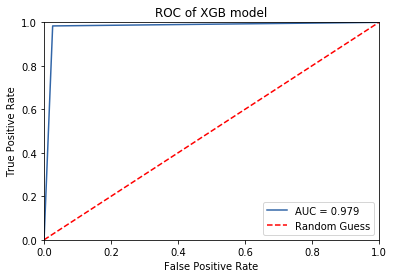

In [31]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(Y_test, best_preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC score of XGB Prediction", end=" ")
print (roc_auc_score(list(Y_test), best_preds))

import matplotlib.pyplot as plt
plt.title('ROC of XGB model')
plt.plot(fpr, tpr, '#3266a8', label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="Random Guess")
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# sample image plot generation

In [32]:
import PIL

raw=mne.io.read_raw_edf("/Volumes/SkAnDH_Xb/EPILEPSY_corr/epilepsy/00000355_s003_t000.edf",preload=True)

for i in range(len(raw.get_data())):
    plt.plot(raw.times,raw.get_data(i)[0])
    plt.title(list(raw.ch_names)[i])
    name=list(raw.ch_names)[i]+".png"
    plt.savefig(name)
    plt.clf()

list_im = list(raw.ch_names)
imgs    = [ PIL.Image.open(i+".png") for i in list_im ]
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'epilepsy.png' )

for i in list(raw.ch_names):
    os.remove(i+".png")

raw.close()

Extracting EDF parameters from /Volumes/SkAnDH_Xb/EPILEPSY_corr/epilepsy/00000355_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331249  =      0.000 ...  1324.996 secs...


/Users/skandhvinayak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app
/Users/skandhvinayak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


<Figure size 432x288 with 0 Axes>

In [33]:
raw=mne.io.read_raw_edf("/Volumes/SkAnDH_Xb/EPILEPSY_corr/no_epilepsy/00002744_s002_t001.edf",preload=True)


for i in range(len(raw.get_data())):
    plt.plot(raw.times,raw.get_data(i)[0])
    plt.title(list(raw.ch_names)[i])
    name=list(raw.ch_names)[i]+".png"
    plt.savefig(name)
    plt.clf()

list_im = list(raw.ch_names)
imgs    = [ PIL.Image.open(i+".png") for i in list_im ]
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'non_epilepsy.png' )

for i in list(raw.ch_names):
    os.remove(i+".png")


Extracting EDF parameters from /Volumes/SkAnDH_Xb/EPILEPSY_corr/no_epilepsy/00002744_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5749  =      0.000 ...    22.996 secs...


/Users/skandhvinayak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/Users/skandhvinayak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>